In [1]:
import psycopg2
import config as creds
import sqlalchemy
from sqlalchemy import create_engine
import numpy as np
from numpy.random import randn
import pandas as pd
from scipy import stats
from datetime import datetime

ELECTRICITY for years 2018-2019, INDIVIDUAL BUILDING TYPES 
Foreign keys: One Hot encode categorical features YEARBUILT and WARD, exclude DCREALPROPERTYID  
Numeric features: sqft, awnd, cldd, htdd, snow
Target feature: kbtu
VotingRegressor - "Mixed Use Property 18-16, 19-17"

CONNECT TO DATABASE:

In [2]:
user=creds.PGUSER
password=creds.PGPASSWORD
host=creds.PGHOST
port=5432
database=creds.PGDATABASE

engine_str=f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(engine_str)
conn = engine.raw_connection()
print('Connected')
cur = conn.cursor()
print('Cursor created')

Connected
Cursor created


EXTRACT DATASET:

In [3]:
query='''
SELECT b.kbtu
      ,b.REPORTEDBUILDINGGROSSFLOORAREA
      ,b.dcrealpropertyid
      ,b.ward
      ,b.yearbuilt
      ,b.primarypropertytype_selfselect
      ,b.elegas
      ,n.awnd
      ,n.cldd
      ,n.htdd
      ,n.snow
      ,n.tavg
      ,n.wdf2
      ,n.wdf5
      ,n.wsf2
      ,n.wsf5
      ,n.date 
FROM buildings_data b
LEFT OUTER join noaa_data n
ON b.REPORTINGYEAR = n.WEATHERYEAR
WHERE b.MONTH = n.MONTH
AND b.ELEGAS = 'E'
AND b.PRIMARYPROPERTYTYPE_SELFSELECT = '9'
AND b.REPORTINGYEAR BETWEEN 2018 AND 2019
AND b.YEARBUILT > 0
AND b.REPORTEDBUILDINGGROSSFLOORAREA > 50000;
'''

data=pd.read_sql(query,conn)
data.head()

,kbtu,reportedbuildinggrossfloorarea,dcrealpropertyid,ward,yearbuilt,primarypropertytype_selfselect,elegas,awnd,cldd,htdd,snow,tavg,wdf2,wdf5,wsf2,wsf5,date
0,286296.0,87138.0,6264_0800,8,2011,9,E,9.8,0.0,906.0,1.2,35.8,300.0,310.0,36.0,49.0,2018-01
1,179300.6,108616.0,1874_0801,3,1964,9,E,9.8,0.0,906.0,1.2,35.8,300.0,310.0,36.0,49.0,2018-01
2,1256942.1,148194.0,1786_0821,3,1963,9,E,9.8,0.0,906.0,1.2,35.8,300.0,310.0,36.0,49.0,2018-01
3,186431.7,55606.0,0113_0060,2,1985,9,E,9.8,0.0,906.0,1.2,35.8,300.0,310.0,36.0,49.0,2018-01
4,0.0,93383.0,4335_0070,5,1966,9,E,9.8,0.0,906.0,1.2,35.8,300.0,310.0,36.0,49.0,2018-01


In [4]:
data.isnull().values.any()

False

FORMAT COLUMNS:

In [5]:
#CONVERT 'Date' COLUMN TO datetime format

#data["reportingyear"] = data["reportingyear"].astype(str)
#data['month']=data['month'].apply(lambda x: '{0:0>2}'.format(x))
#data['date_time'] = data[['reportingyear', 'month']].agg('-'.join, axis=1)
#data['date_time'] = (data.date_time + "-01")
#data['date_time'] = datetime.strptime('date_time', "%Y-%m-%d")
data['datetime']=pd.to_datetime(data['date'])

In [6]:
data['primarypropertytype_selfselect'].dtype

dtype('O')

In [7]:
data['primarypropertytype_selfselect']=data['primarypropertytype_selfselect'].astype('int32')

In [8]:
data.set_index('datetime', inplace=True)
data.head()

,kbtu,reportedbuildinggrossfloorarea,dcrealpropertyid,ward,yearbuilt,primarypropertytype_selfselect,elegas,awnd,cldd,htdd,snow,tavg,wdf2,wdf5,wsf2,wsf5,date
datetime,,,,,,,,,,,,,,,,,
2018-01-01,286296.0,87138.0,6264_0800,8,2011,9,E,9.8,0.0,906.0,1.2,35.8,300.0,310.0,36.0,49.0,2018-01
2018-01-01,179300.6,108616.0,1874_0801,3,1964,9,E,9.8,0.0,906.0,1.2,35.8,300.0,310.0,36.0,49.0,2018-01
2018-01-01,1256942.1,148194.0,1786_0821,3,1963,9,E,9.8,0.0,906.0,1.2,35.8,300.0,310.0,36.0,49.0,2018-01
2018-01-01,186431.7,55606.0,0113_0060,2,1985,9,E,9.8,0.0,906.0,1.2,35.8,300.0,310.0,36.0,49.0,2018-01
2018-01-01,0.0,93383.0,4335_0070,5,1966,9,E,9.8,0.0,906.0,1.2,35.8,300.0,310.0,36.0,49.0,2018-01


In [9]:
data.columns

Index(['kbtu', 'reportedbuildinggrossfloorarea', 'dcrealpropertyid', 'ward',
       'yearbuilt', 'primarypropertytype_selfselect', 'elegas', 'awnd', 'cldd',
       'htdd', 'snow', 'tavg', 'wdf2', 'wdf5', 'wsf2', 'wsf5', 'date'],
      dtype='object')

In [10]:
data.dtypes

kbtu                              float64
reportedbuildinggrossfloorarea    float64
dcrealpropertyid                   object
ward                                int64
yearbuilt                           int64
primarypropertytype_selfselect      int32
elegas                             object
awnd                              float64
cldd                              float64
htdd                              float64
snow                              float64
tavg                              float64
wdf2                              float64
wdf5                              float64
wsf2                              float64
wsf5                              float64
date                               object
dtype: object

<AxesSubplot:>

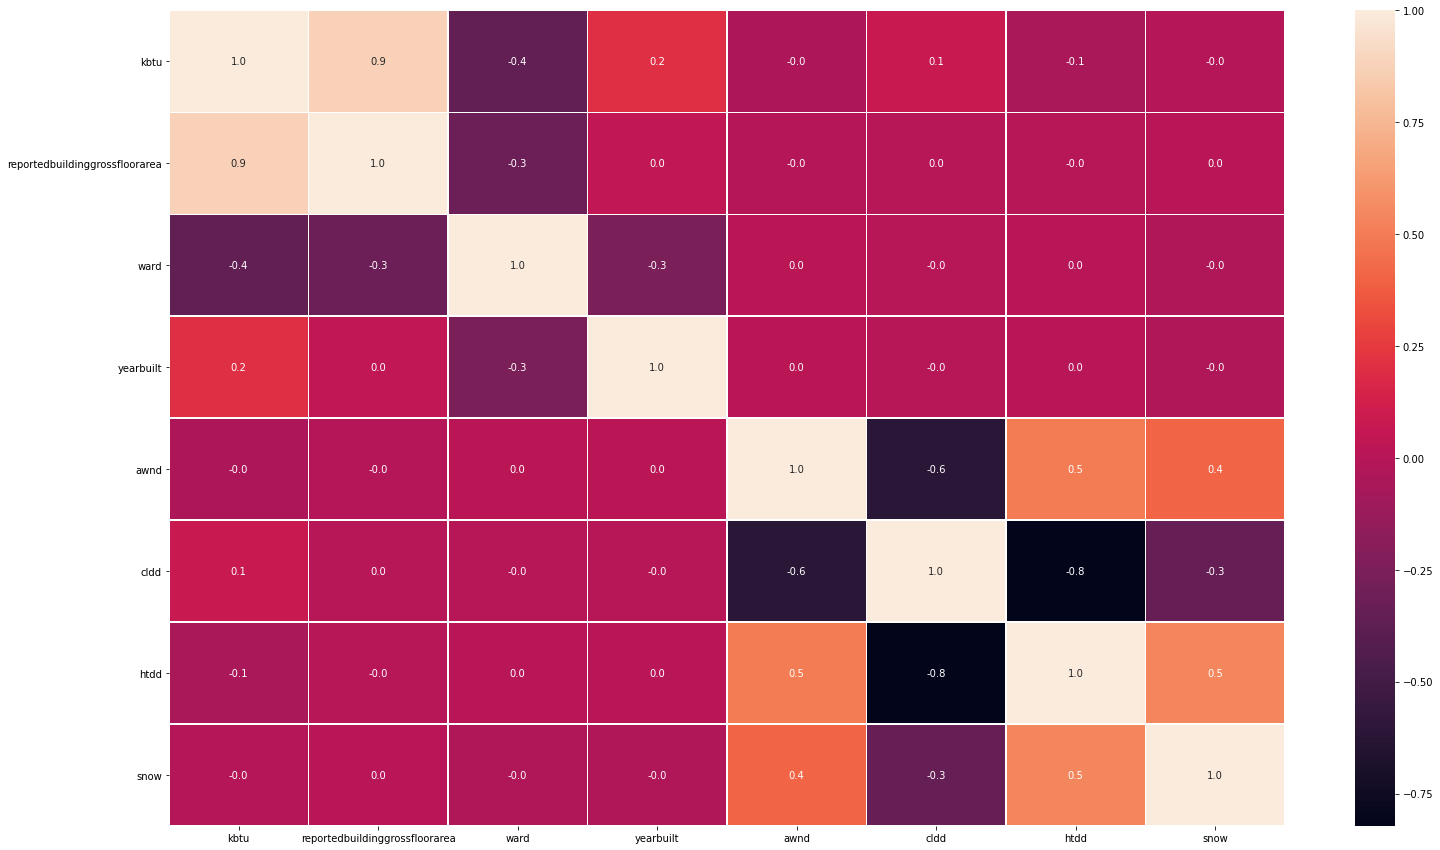

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(25,15))
ftr = list(["kbtu", "reportedbuildinggrossfloorarea", "ward", "yearbuilt", "awnd", "cldd", "htdd", "snow"])
corrMatrix = data[ftr].corr()
sns.heatmap(corrMatrix, annot=True, fmt='.1f', linewidths=.5)

DEFINE FEATURES:

In [12]:
TARGET = "kbtu"
COLS = ['reportedbuildinggrossfloorarea', 'ward', 'yearbuilt', 'awnd', 'cldd', 'htdd', 'snow', 'datetime']

def make_sklearn_data(df=data, target=TARGET, cols=COLS):
    df = df.reset_index()
    X, y = df[cols], df[target]
    return X, y

In [13]:
features = ['reportedbuildinggrossfloorarea', 'ward', 'yearbuilt', 'awnd', 'cldd', 'htdd', 'snow']
X, y = make_sklearn_data(cols=features)

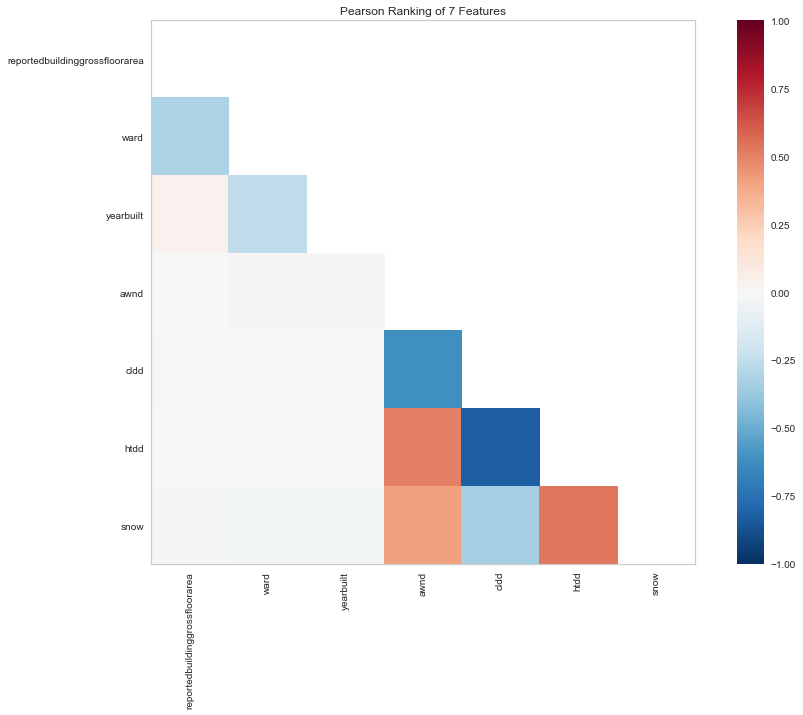

<AxesSubplot:title={'center':'Pearson Ranking of 7 Features'}>

In [14]:
#Rank2D
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', features=features, size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

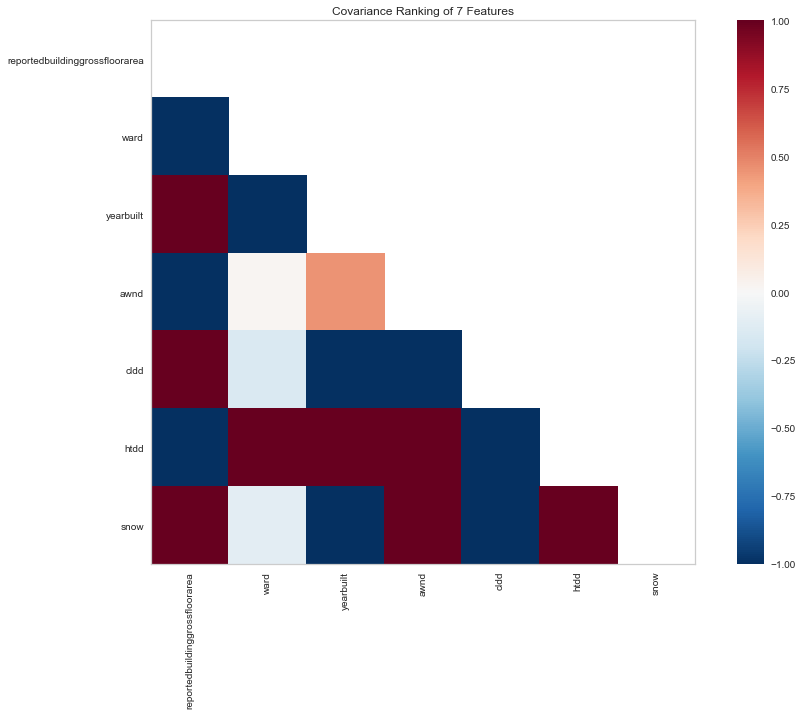

<AxesSubplot:title={'center':'Covariance Ranking of 7 Features'}>

In [15]:
# Instantiate the visualizer with the Covariance algorithm
visualizer = Rank2D(algorithm='covariance', features=features, size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

/Users/carlakcoulson/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


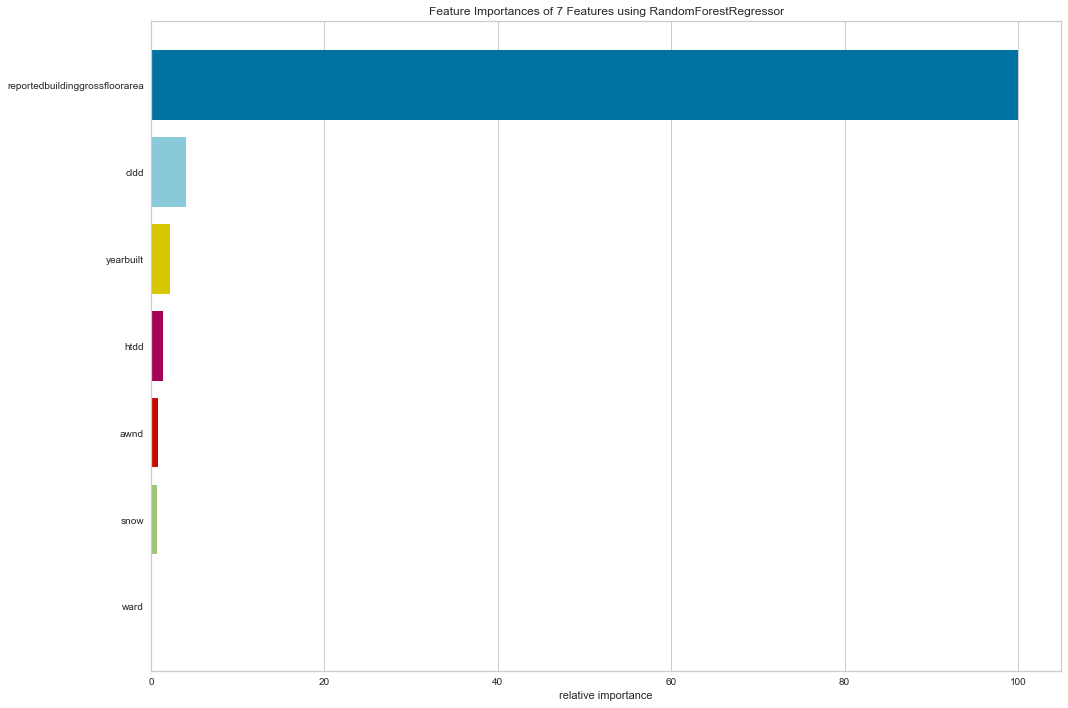

<AxesSubplot:title={'center':'Feature Importances of 7 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [16]:
#Feature Importances
import yellowbrick as yb
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.features import RadViz
from yellowbrick.features import FeatureImportances


model = RandomForestRegressor(n_estimators=10)
viz = FeatureImportances(model, labels=features, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()

/Users/carlakcoulson/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


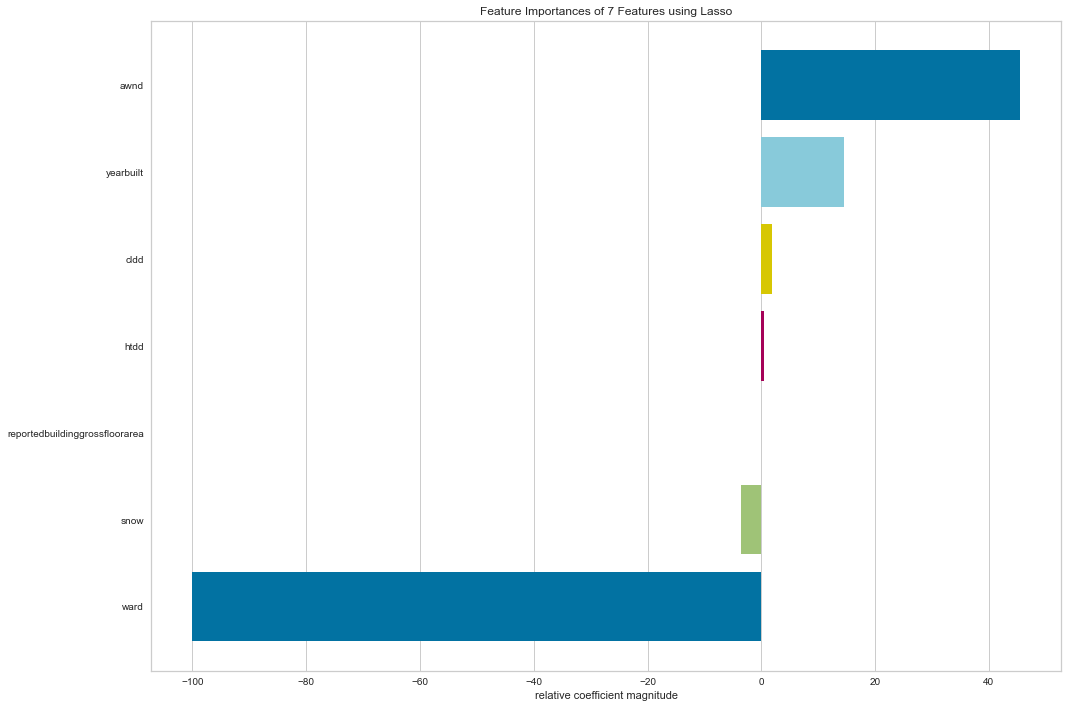

<AxesSubplot:title={'center':'Feature Importances of 7 Features using Lasso'}, xlabel='relative coefficient magnitude'>

In [17]:
#Feature Importances
import yellowbrick as yb
from sklearn.linear_model import Lasso
from yellowbrick.features import RadViz
from yellowbrick.features import FeatureImportances


model = Lasso()
viz = FeatureImportances(model, labels=features, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='datetime_cos', ylabel='datetime_sin'>

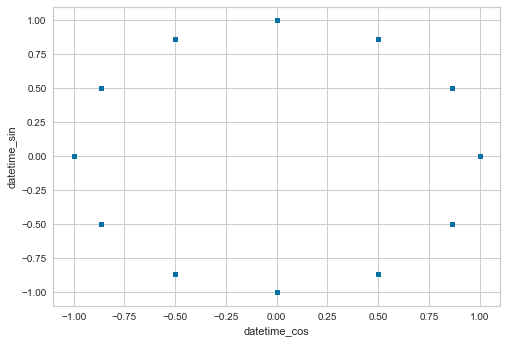

In [18]:
#CYCLIC ENCODER:  to capture temporal cycles (yearly).
from sklearn.base import BaseEstimator, TransformerMixin


class CyclicEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_extract="month"):
        if date_extract not in {"minute", "hour", "week", "month", "year"}:
            raise ValueError(f"specify correct date component to extract, not {date_extract}")
        self.date_extract = date_extract
    
    def get_date_component(self, x):
        if self.date_extract == "month":
            return x.dt.month
        elif self.date_extract == "year":
            return x.dt.year
        else:
            raise NotImplementedError(f"{self.date_extract} date component not implemented yet")
            
    def fit(self, X, y=None):
        self.cycle_max_ = self.get_date_component(X).max()
        return self

    def transform(self, X,  y=None):
        cols = []
        names = []
        x = self.get_date_component(X)
        xn = 2 * np.pi * x / self.cycle_max_
        cols.append(np.cos(xn))
        names.append(f"{X.name}_cos")
        cols.append(np.sin(xn))
        names.append(f"{X.name}_sin")
        return pd.DataFrame(np.asarray(cols).T, columns=names)

    
ce = CyclicEncoder().fit_transform(data.reset_index()["datetime"])
ce.plot(x="datetime_cos", y="datetime_sin", kind="scatter")

In [19]:
#FEATURE EXTRACTION
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder

extraction = Pipeline([
    ('column_selection', ColumnTransformer([
        ('time_components', FeatureUnion([
            ('month', CyclicEncoder(date_extract='month')), 
            ('year', CyclicEncoder(date_extract='year')), 
        ]), 'datetime'),
        ('ward_one_hot', OneHotEncoder(handle_unknown='ignore'), ['ward']),
        ('yearbuilt_one_hot', OneHotEncoder(handle_unknown='ignore'), ['yearbuilt']),
    ], remainder="passthrough")),
])

def make_energy_pipeline(model, append_transformers=None, fe=extraction):
    pipe = clone(fe)
    
    if append_transformers:
        for step in append_transformers:
            pipe.steps.append(step)
    
    pipe.steps.append(["model", clone(model)])
    return pipe

In [20]:
#Test the Feature Extraction Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(*make_sklearn_data(), test_size=0.2)

model = make_energy_pipeline(LinearRegression())
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9099208927103517

In [21]:
#TIME SERIES CROSS VALIDATION
from functools import partial
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rmse = partial(mean_squared_error, squared=False)


def time_series_evaluate(model, X, y):
    """
    Performs time series cross validation on the model, returning the
    cross validated r2, mse, and mae of the regressor, along with the 
    final fitted model, fitted on all of the data.
    """
    cv = TimeSeriesSplit(12)
    scores = {}
    
    scores["r2"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(r2_score))
    scores["mse"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_squared_error))
#     scores["rmse"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(rmse))
    scores["mae"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
    
    model.fit(X, y)
    return model, scores

In [22]:
# LINEAR MODEL
X, y = make_sklearn_data()
lm = make_energy_pipeline(LinearRegression())
time_series_evaluate(lm, X, y)

(Pipeline(steps=[('column_selection',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('time_components',
                                                   FeatureUnion(transformer_list=[('month',
                                                                                   CyclicEncoder()),
                                                                                  ('year',
                                                                                   CyclicEncoder(date_extract='year'))]),
                                                   'datetime'),
                                                  ('ward_one_hot',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['ward']),
                                                  ('yearbuilt_one_hot',
                                                   OneHotEncoder(hand

In [23]:
#Second order polynomial regression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

qm = make_energy_pipeline(SGDRegressor(), [('quad', PolynomialFeatures(2))])
time_series_evaluate(qm, X, y)

(Pipeline(steps=[('column_selection',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('time_components',
                                                   FeatureUnion(transformer_list=[('month',
                                                                                   CyclicEncoder()),
                                                                                  ('year',
                                                                                   CyclicEncoder(date_extract='year'))]),
                                                   'datetime'),
                                                  ('ward_one_hot',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['ward']),
                                                  ('yearbuilt_one_hot',
                                                   OneHotEncoder(hand

In [24]:
from sklearn.ensemble import RandomForestRegressor

rfm = make_energy_pipeline(RandomForestRegressor(n_estimators=10, max_depth=3))
time_series_evaluate(rfm, X, y)

(Pipeline(steps=[('column_selection',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('time_components',
                                                   FeatureUnion(transformer_list=[('month',
                                                                                   CyclicEncoder()),
                                                                                  ('year',
                                                                                   CyclicEncoder(date_extract='year'))]),
                                                   'datetime'),
                                                  ('ward_one_hot',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['ward']),
                                                  ('yearbuilt_one_hot',
                                                   OneHotEncoder(hand

In [25]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

start  = time.time()

r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)

X, y = make_sklearn_data()
er = make_energy_pipeline(VotingRegressor([('lr', r1), ('rf', r2)]))
print(time_series_evaluate(er, X, y))
print("Time = {:0.3f} seconds".format(time.time()-start))

(Pipeline(steps=[('column_selection',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('time_components',
                                                  FeatureUnion(transformer_list=[('month',
                                                                                  CyclicEncoder()),
                                                                                 ('year',
                                                                                  CyclicEncoder(date_extract='year'))]),
                                                  'datetime'),
                                                 ('ward_one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ward']),
                                                 ('yearbuilt_one_hot',
                                                  OneHotEncoder(handle_unknown='

In [26]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

start  = time.time()

X, y = make_sklearn_data()

estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]

er = make_energy_pipeline(StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
))
print(time_series_evaluate(er, X, y))
print("Time = {:0.3f} seconds".format(time.time()-start))

/Users/carlakcoulson/opt/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/carlakcoulson/opt/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/carlakcoulson/opt/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/carlakcoulson/opt/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/carlakcoulson/opt/miniconda3/lib/python3.8/site-packages/skle

(Pipeline(steps=[('column_selection',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('time_components',
                                                  FeatureUnion(transformer_list=[('month',
                                                                                  CyclicEncoder()),
                                                                                 ('year',
                                                                                  CyclicEncoder(date_extract='year'))]),
                                                  'datetime'),
                                                 ('ward_one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ward']),
                                                 ('yearbuilt_one_hot',
                                                  OneHotEncoder(handle_unknown='

In [27]:
conn.close()
print('Closed')

Closed
